# Regression with Fourier Features - Part 2

Initially observed in: https://arxiv.org/abs/2006.10739

The inclusion of Fourier features allows neural networks to capture high frequency information of the target function. In this short note, we compare a vanilla DNN with another Fourier-feature embedded DNN on the task of learning a (noise-perturbed) PDE solution in both space and time domains. The Fourier features embedding is done in both directions and results are aggregated.

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy
from collections import OrderedDict

# set random seeds
np.random.seed(10)
torch.manual_seed(10);
torch.set_default_dtype(torch.float64)

import numpy as np    
import matplotlib.pyplot as plt

import time
import pylab as pl
from IPython import display
from IPython.display import clear_output

# import neural nets
from PINN.utils.dnn import *

Generate data from the following PDE:
$$
    \frac{\partial u}{\partial t} + u_0\sin(\omega t)\frac{\partial u}{\partial x} = 0
$$ whose analytical solution is given by:
$$
    u(t,x) = \exp\bigg(
            -k[x - x_0 - 2v_0\omega^{-1}\sin^2(\frac{1}{2}\omega t)]^2
        \bigg)
$$

In [2]:
# parameters
x0 = 2.0
v0 = 2.0
k = 5.0
omega = 2.0*np.pi
# time grid
t_start = 0.0
t_end = 2*np.pi
dt = 0.001
tgrid = np.arange(t_start, t_end, dt)
nt = len(tgrid)
# spatial grid
x_left, x_right = 0.0, 5.0
dx = 0.005
xgrid = np.arange(x_left, x_right, dx)
nx = len(xgrid)

# solution
u_sol = np.zeros([nt, nx])
for i in range(nt):
    t = tgrid[i]
    u_sol[i, :] = np.exp(-k * (( xgrid - x0 ) - (2*v0/omega) * (np.sin(0.5*omega*t) ** 2)) ** 2 )

# subsample grids
subsample_t = 6
subsample_x = 2
xgrid_small = xgrid.reshape(1, -1)[:, 0:-1:subsample_x].squeeze(),
tgrid_small = tgrid.reshape(1, -1)[:, 0:-1:subsample_t].squeeze()
u_sol_small = u_sol[0:-1:subsample_t, 0:-1:subsample_x]
print(u_sol_small.shape)

(1048, 500)


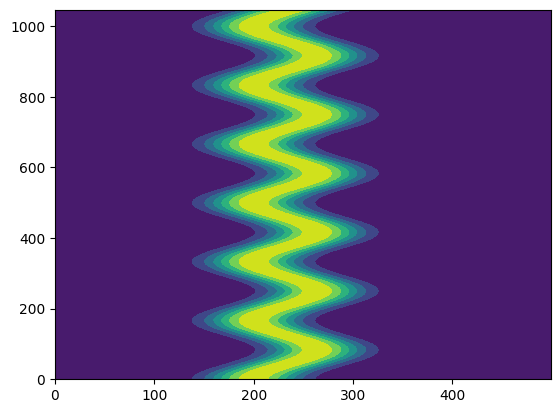

In [3]:
plt.figure(1);
plt.contourf(u_sol_small);

In [4]:
# create training data
X = cartesian_data(torch.tensor(tgrid_small.flatten()), torch.tensor(xgrid_small[0].flatten()))
y = torch.tensor(u_sol_small).T.flatten().reshape(-1, 1)
#y = torch.tensor(u_sol_small2).T.flatten().reshape(-1, 1)

# define training function
def train(inputs, outputs, model, optim, scheduler, batch_size, epochs, shuffle=True):
    X, y = inputs, outputs
    nx = X.shape[0]
    num_batches = int(nx/batch_size)
    for i in range(epochs):
        print("============================================================\n")
        print("Epoch = {}\n".format(i+1));
        print("============================================================\n")
        model.train()
        if shuffle:
            tmp = np.random.permutation(nx)
            X, y = X[tmp, :].data.clone(), y[tmp, :].data.clone()
        for idx in range(num_batches):
            if idx % 100 == 0:
                print("| => | Batch {} |\n".format(idx+1))
        # closure definition
            def closure():
                optim.zero_grad()
                start_idx = idx*batch_size
                end_idx = (idx+1)*batch_size
                if idx + 1 == num_batches:
                    # if last batch
                    end_idx = -1
                Xb, yb = X[start_idx:end_idx, :].data.clone(), y[start_idx:end_idx, :].data.clone()

                # require gradients
                Xb.requires_grad = True
                # make a prediction on the batch
                y_pred = model.forward(Xb)
                # compute L^2 loss
                loss = torch.mean((y_pred - yb)**2)
                # backpropagate
                loss.backward()
                if idx % 100 == 0:
                    print("==> Batch {} loss = {}".format(idx, loss.item()))
                return loss
            optim.step(closure=closure)
        if scheduler:
            # step scheduler after epoch if there is one
            scheduler.step()
            print("---------- \n")
            print("++ Learning rate reduced, now at = {}".format(scheduler.get_last_lr()[0]))

In [ ]:
# test vanilla neural net
nn_vanilla = DNN(layers=[2, 32, 32, 1])
nn_vanilla

In [ ]:
optim = torch.optim.Adam(
    nn_vanilla.parameters(),
    lr=8e-3
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9999)
train(X, y, nn_vanilla, optim, scheduler, 2**12, 50, shuffle=True)

In [ ]:
# make predictions and compare contour plots
nt_small = len(tgrid_small.flatten())
nx_small = len(xgrid_small[0].flatten())
u_sol_predict = nn_vanilla(X).reshape([nx_small, nt_small]).detach().numpy().T
u_sol_exact = y.reshape([nx_small, nt_small]).detach().numpy().T

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].contourf(u_sol_predict);
ax[1].contourf(u_sol_exact);

In [ ]:
# testing Fourier embedded net in 2d
nn_fourier2d = FourierEmbeddedDNN2d(
    200,
    4, 
    1,
    m=15, 
    freq_stds={"time": [1.0, 2.0, 5.0, 10.0], "space": [1.0]}
)
optim = torch.optim.Adam(
    nn_fourier2d.parameters(),
    lr=8e-3
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9999)
train(X, y, nn_fourier2d, optim, scheduler, 2**12, 50, shuffle=True)


Epoch = 1


| => | Batch 1 |

==> Batch 0 loss = 0.40578627770075537
| => | Batch 101 |

==> Batch 100 loss = 0.09029339054139807
---------- 

++ Learning rate reduced, now at = 0.0079992

Epoch = 2


| => | Batch 1 |

==> Batch 0 loss = 0.08837590459665279
| => | Batch 101 |

==> Batch 100 loss = 0.08919810373251509
---------- 

++ Learning rate reduced, now at = 0.007998400079999999

Epoch = 3


| => | Batch 1 |

==> Batch 0 loss = 0.08547511582151002
| => | Batch 101 |

==> Batch 100 loss = 0.08801545613681706
---------- 

++ Learning rate reduced, now at = 0.007997600239991999

Epoch = 4


| => | Batch 1 |

==> Batch 0 loss = 0.08306573219696876
| => | Batch 101 |

==> Batch 100 loss = 0.08785572430631416
---------- 

++ Learning rate reduced, now at = 0.007996800479968

Epoch = 5


| => | Batch 1 |

==> Batch 0 loss = 0.0845969890699769
| => | Batch 101 |

==> Batch 100 loss = 0.08570516613185378
---------- 

++ Learning rate reduced, now at = 0.007996000799920003

Epoch = 6


| 

| => | Batch 101 |

==> Batch 100 loss = 0.08794970183325572
---------- 

++ Learning rate reduced, now at = 0.007979225979211954

Epoch = 27


| => | Batch 1 |

==> Batch 0 loss = 0.08693647858645326
| => | Batch 101 |

==> Batch 100 loss = 0.08354562287336649
---------- 

++ Learning rate reduced, now at = 0.007978428056614032

Epoch = 28


| => | Batch 1 |

==> Batch 0 loss = 0.07931846066331649


In [ ]:
nt_small = len(tgrid_small.flatten())
nx_small = len(xgrid_small[0].flatten())
u_sol_predict_fourier = nn_fourier2d(X).reshape([nx_small, nt_small]).detach().numpy().T
u_sol_exact_fourier = y.reshape([nx_small, nt_small]).detach().numpy().T

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].contourf(u_sol_predict_fourier)
ax[1].contourf(u_sol_exact_fourier)

In [ ]:
np.mean((u_sol_predict_fourier-u_sol_exact_fourier)**2)

In [ ]:
# testing Fourier embedded net in 2d (old architecture)
nn_fourier2d_old = FourierEmbeddedDNN2dOld(
    layers=[30, 128, 128, 128, 1],
    m=15, 
    freq_stds=np.array([[1.,2.,10.,20.,100.], [1.,2.,3.,4.,5.]]).T
)
optim = torch.optim.Adam(
    nn_fourier2d_old.parameters(),
    lr=8e-3
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9999)
train(X, y, nn_fourier2d_old, optim, scheduler, 2**12, 50, shuffle=True)

In [ ]:
nt_small = len(tgrid_small.flatten())
nx_small = len(xgrid_small[0].flatten())
u_sol_predict_fourier = nn_fourier2d_old(X).reshape([nx_small, nt_small]).detach().numpy().T
u_sol_exact_fourier = y.reshape([nx_small, nt_small]).detach().numpy().T

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].contourf(u_sol_predict_fourier)
ax[1].contourf(u_sol_exact_fourier)

In [ ]:
np.mean((u_sol_predict_fourier-u_sol_exact_fourier)**2)

In [ ]:
dt = tgrid_small[1]-tgrid_small[0]
for idx in range(nt_small):
    if idx % 5 == 0:
        plt.figure(1);
        plt.plot(xgrid_small[0].flatten(), u_sol_predict_fourier[idx, :], lw=2., color="black");
        plt.plot(xgrid_small[0].flatten(), u_sol_exact_fourier[idx, :], "--", lw=8.0, color="red", alpha=0.6);
        plt.plot(xgrid_small[0].flatten(), u_sol_predict[idx, :], lw=2., color="blue", alpha=0.5);
        display.clear_output(wait=True)
        display.display(pl.gcf())
        plt.clf()
        plt.title(r"$t = {}$".format(dt*(idx+1)))
        time.sleep(0.01);